# Preprocesado de imágenes usando Nvidia CUDA streams
En este notebook se muestra el impacto del uso de Nvidia CUDA streams sobre el procesado de imágenes.

## Intalación de las herramientas necesarias
En este apartado, se realiza la instalación de las herramientas necesarias que serán usadas a lo largo del notebook.

## Carga de las imágenes
En este apartado, se cargan las imágenes en una estructura para su posterior manipulación y utilización.

In [8]:
import os

#Gestión imagenes
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage import data, color
import cv2 as cv

import joblib
import matplotlib.pyplot as plt
import numpy as np
from numba import vectorize, cuda

import timeit
from time import perf_counter

from itertools import cycle


In [10]:
home_dir = "./dataset/"
figures_dir = "./figuras"
pickles_dir = "./pickles"

def load_images(src_path,pklname,width=1620, height=1080):

    height = height if height is not None else width
    pklname = pickles_dir + f"/{pklname}_{width}x{height}px.pkl"
    data=dict()

    data['description'] = 'Imagenes ({0}x{1}) en RGB'.format(int(width), int(height))
    data['filename'] = []
    data['data'] = []
    for file in os.listdir(src_path):
        if file[-3:] in {'jpg','JPG'}:
            im = imread(os.path.join(src_path, file))
            im = resize(im, (width, height, 3))
            data['filename'].append(os.path.join(src_path, file))
            data['data'].append(im)
    joblib.dump(data, pklname)


In [11]:
base_name = 'imagenes'
width = 512
height = 512
if (not os.path.exists(pickles_dir + f'/{base_name}_{width}x{height}px.pkl')):
    load_images(src_path=home_dir, pklname=base_name, width=width, height=height)


In [12]:
data = joblib.load(pickles_dir + f'/{base_name}_{width}x{height}px.pkl')

# Mostramos estadísticas sobre el dataset
print('Número de imagenes: ', len(data['data']))
print('Claves: ', list(data.keys()))
print('Descripción: ', data['description'])
print('Dimensiones de las imágenes: ', data['data'][0].shape)

Número de imagenes:  361
Claves:  ['description', 'filename', 'data']
Descripción:  Imagenes (512x512) en RGB
Dimensiones de las imágenes:  (512, 512, 3)


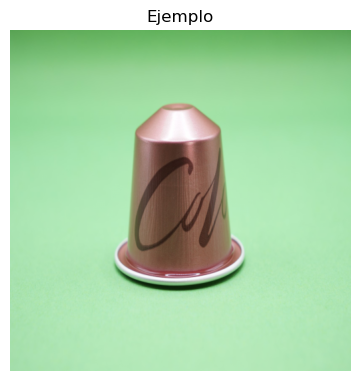

In [13]:
# Configuramos la figura y los ejes de matplotlib
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(7,4)
fig.tight_layout()


axes.imshow(data['data'][0])
axes.axis('off')
axes.set_title("Ejemplo")

# Guardamos la imagen
#plt.savefig(figures_exploracion_dir + '/normal_vs_neumonia.png')

# Mostramos la figura
plt.show()

## Procesado de las imágenes
En este apartado, se aplican los diferentes filtros a las imágenes, recopilando métricas para su posterior análisis.

### Filtro de media , Versión CPU

Tamaño:  (512, 512)


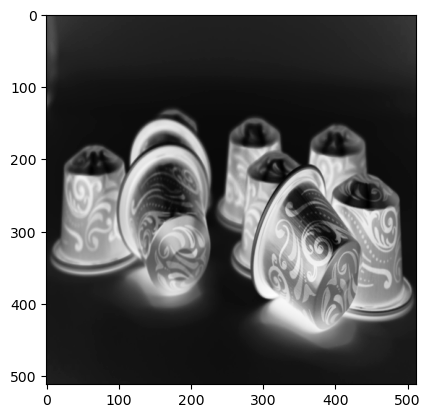

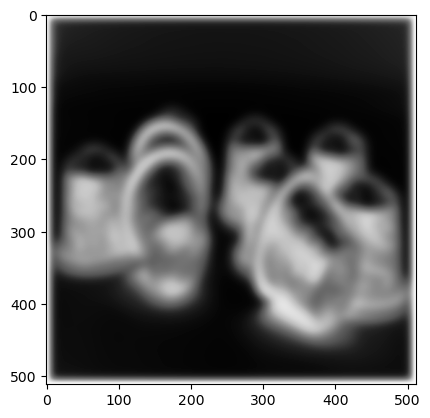

In [14]:
def media_blur_cpu(input):
    toret = np.zeros_like(input)
    for row in range(1, input.shape[0] - 1):
        for col in range(1, input.shape[1] - 1):
            toret[row][col] = 0.25*(input[row-1][col]+input[row+1][col]+input[row][col-1]+input[row][col+1])
    return toret

#Division por canales
b, g, r = cv.split(data['data'][360])
num_cycles = 100
capsula = b
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')
for i in range(num_cycles):
    capsula_cpu = media_blur_cpu(capsula)
    capsula = capsula_cpu
fig, ax = plt.subplots()
im = ax.imshow(capsula_cpu, cmap='Greys')

### Filtro de media, versión Cuda

Pilla los de al rededor, los suma y hace la media de estos

Tamaño:  (512, 512)


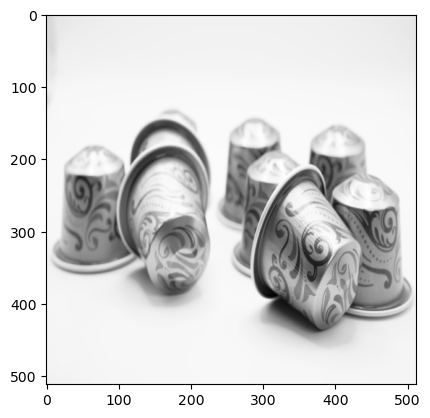

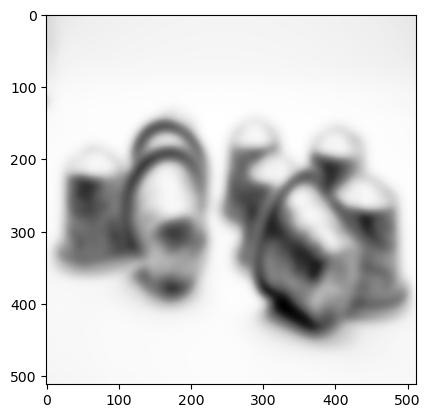

In [21]:
@cuda.jit
def blur(input, output):
    x, y = cuda.grid(2)
    if x>0 and y>0 and x<(input.shape[0]-1) and y<(input.shape[1]-1):
        output[x][y] = 0.25*(input[x-1][y]+input[x+1][y]+input[x][y-1]+input[x][y+1])
    else:
        output[x][y] = input [x][y]

num_cycles = 100

#16x32, 32 hilos por cada bloque
blocks = (16, 16) 
threads_per_block = (32, 32)

#Division por canales
b, g, r = cv.split(data['data'][360])

capsula = (255.-b)/255.0
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')

d_capsula = cuda.to_device(capsula)
d_imOut = cuda.device_array(shape=(512,512), dtype=np.float32)

for i in range(num_cycles):
    blur[blocks,threads_per_block](d_capsula,d_imOut)
    d_capsula = d_imOut

capsula_blurred = d_capsula.copy_to_host()
fig, ax = plt.subplots()
im = ax.imshow(capsula_blurred, cmap='Greys')



### Filtro Sobel, CPU

Tamaño:  (512, 512)


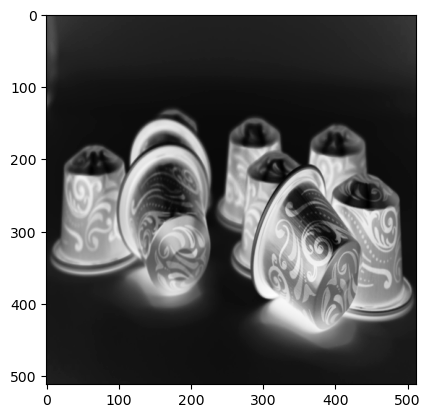

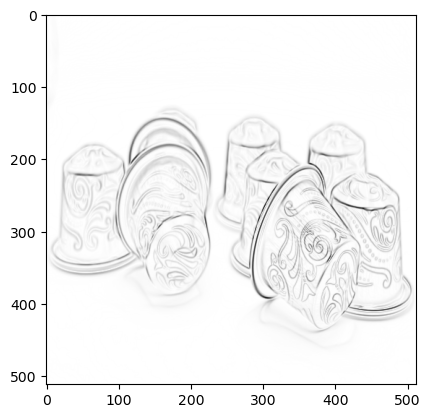

In [22]:
from math import sqrt,pow

def sobel_cpu(input):
    toret = np.zeros_like(input)
    for row in range(2, input.shape[0] - 2):
        for col in range(2, input.shape[1] - 2):
                gx = (input[row, col] - input[row + 2, col] +
                       2 * input[row, col + 1] - 2 * input[row + 2, col + 1] +
                       input[row, col + 2] - input[row + 2, col + 2])
                gy = (input[row, col] - input[row, col + 2] +
                      2 * input[row + 1, col] - 2 * input[row + 1, col + 2] +
                      input[row + 2, col] - input[row + 2, col + 2])
                toret[row][col] = sqrt((float)(pow(gx,2) + pow(gy,2)))
    return toret

#Division por canales
b, g, r = cv.split(data['data'][360])
capsula = b

print("Tamaño: ", capsula.shape)

fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')

capsula_cpu = sobel_cpu(capsula)
capsula = capsula_cpu

fig, ax = plt.subplots()
im = ax.imshow(capsula_cpu, cmap='Greys')

### Filtro Sobel, en CUDA

Tamaño:  (512, 512)


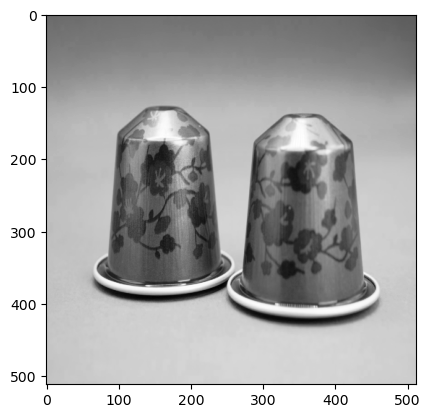

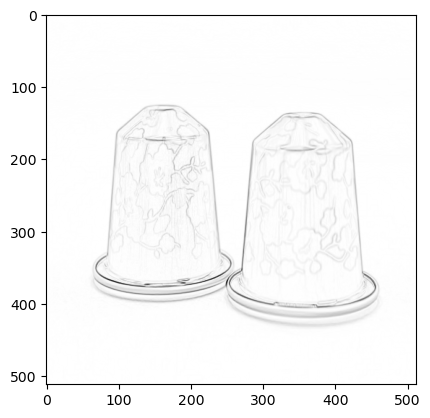

In [23]:
from math import sqrt,pow

@cuda.jit()
def sobel_filter(input_image, output_image):
    x, y = cuda.grid(2)
    
    if x < input_image.shape[0] - 2 and y < input_image.shape[1] - 2:
        gx = (input_image[x, y] - input_image[x + 2, y] +
              2 * input_image[x, y + 1] - 2 * input_image[x + 2, y + 1] +
              input_image[x, y + 2] - input_image[x + 2, y + 2])
              
        gy = (input_image[x, y] - input_image[x, y + 2] +
              2 * input_image[x + 1, y] - 2 * input_image[x + 1, y + 2] +
              input_image[x + 2, y] - input_image[x + 2, y + 2])
        #for z in gx.shape(0):        
        output_image[x, y] = sqrt((float)(pow(gx,2) + pow(gy,2)))
        
#16x32, 32 hilos por cada bloque
blocks = (16, 16) 
threads_per_block = (32, 32)

#Division por canales
b, g, r = cv.split(data['data'][265])

capsula = (255.-b)/255.0
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')

blockspergrid_x = (capsula.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
blockspergrid_y = (capsula.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

d_capsula = cuda.to_device(capsula)
d_imOut = cuda.device_array(shape=(512,512), dtype=np.float32)


sobel_filter[blocks,threads_per_block](d_capsula,d_imOut)
d_capsula = d_imOut

capsula_blurred = d_capsula.copy_to_host()
fig, ax = plt.subplots()
im = ax.imshow(capsula_blurred, cmap='Greys')

### Filtro cálculo del máximo, CPU

Tamaño:  (512, 512)


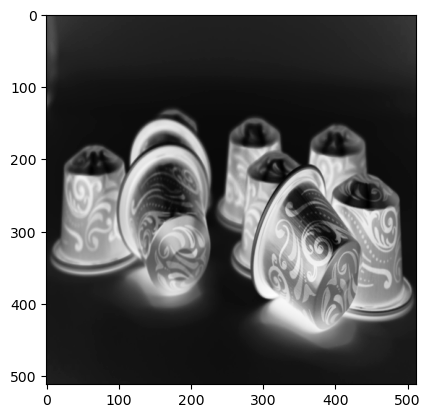

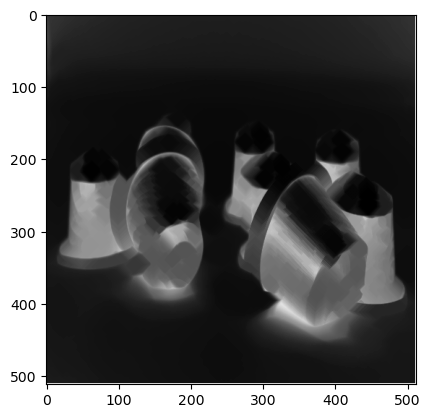

In [24]:
def maximo_cpu(input):
    toret = np.zeros_like(input)
    for row in range(1, input.shape[0] - 1):
        for col in range(1, input.shape[1] - 1):
            toret[row][col] = max(input[row-1][col],input[row+1][col],input[row][col-1],input[row][col+1])
    return toret

#Division por canales
b, g, r = cv.split(data['data'][360])
num_cycles = 10
capsula = b
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')
for i in range(num_cycles):
    capsula_cpu = maximo_cpu(capsula)
    capsula = capsula_cpu
fig, ax = plt.subplots()
im = ax.imshow(capsula_cpu, cmap='Greys')

### Filtro cálculo del máximo, CUDA

Tamaño:  (512, 512)


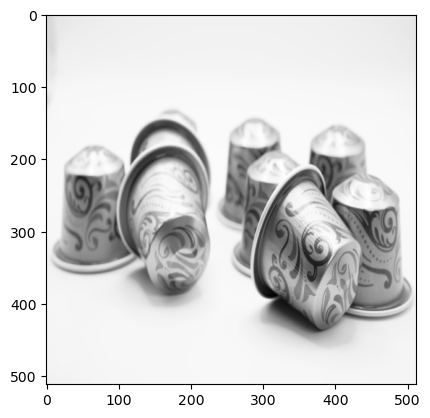

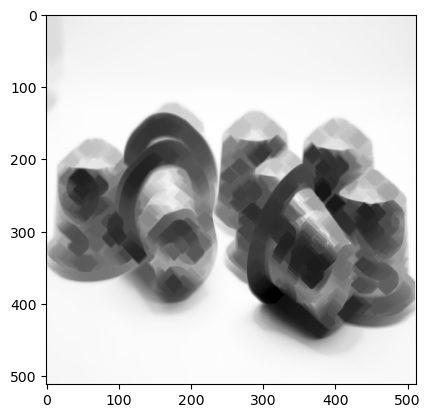

In [25]:
@cuda.jit
def filtro_max(input, output):
    x, y = cuda.grid(2)
    if x>0 and y>0 and x<(input.shape[0]-1) and y<(input.shape[1]-1):
        output[x][y] = max(input[x-1][y],input[x+1][y],input[x][y-1],input[x][y+1])
    else:
        output[x][y] = input [x][y]

num_cycles = 10

#16x32, 32 hilos por cada bloque
blocks = (16, 16) 
threads_per_block = (32, 32)

#Division por canales
b, g, r = cv.split(data['data'][360])

capsula = (255.-b)/255.0
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')

d_capsula = cuda.to_device(capsula)
d_imOut = cuda.device_array(shape=(512,512), dtype=np.float32)

for i in range(num_cycles):
    filtro_max[blocks,threads_per_block](d_capsula,d_imOut)
    d_capsula = d_imOut

capsula_blurred = d_capsula.copy_to_host()
fig, ax = plt.subplots()
im = ax.imshow(capsula_blurred, cmap='Greys')


### Filtro de cálculo del minimo, CPU

Tamaño:  (512, 512)


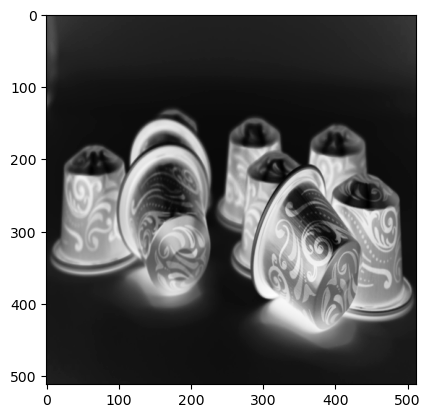

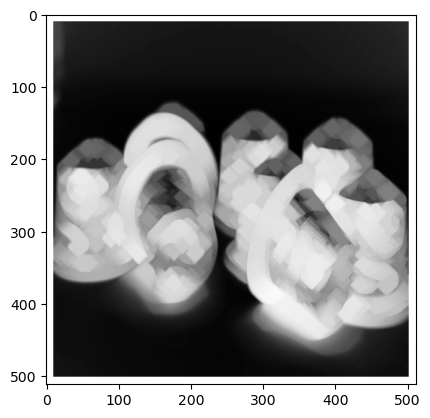

In [26]:
def minimo_cpu(input):
    toret = np.zeros_like(input)
    for row in range(1, input.shape[0] - 1):
        for col in range(1, input.shape[1] - 1):
            toret[row][col] = min(input[row-1][col],input[row+1][col],input[row][col-1],input[row][col+1])
    return toret

#Division por canales
b, g, r = cv.split(data['data'][360])
num_cycles = 10
capsula = b
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')
for i in range(num_cycles):
    capsula_cpu = minimo_cpu(capsula)
    capsula = capsula_cpu
fig, ax = plt.subplots()
im = ax.imshow(capsula_cpu, cmap='Greys')

### Filtro de cálulo del minimo, CUDA

Tamaño:  (512, 512)


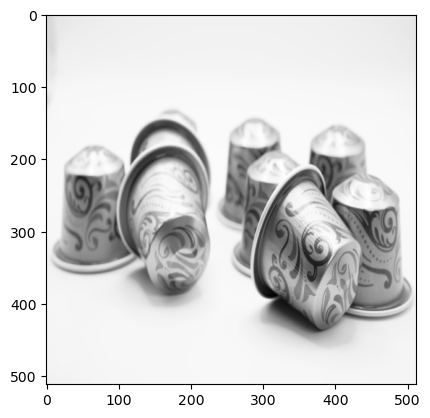

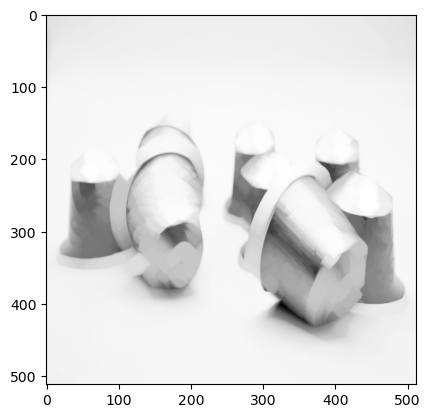

In [27]:
@cuda.jit
def filtro_max(input, output):
    x, y = cuda.grid(2)
    if x>0 and y>0 and x<(input.shape[0]-1) and y<(input.shape[1]-1):
        output[x][y] = min(input[x-1][y],input[x+1][y],input[x][y-1],input[x][y+1])
    else:
        output[x][y] = input [x][y]

num_cycles = 10

#16x32, 32 hilos por cada bloque
blocks = (16, 16) 
threads_per_block = (32, 32)

#Division por canales
b, g, r = cv.split(data['data'][360])

capsula = (255.-b)/255.0
print("Tamaño: ", capsula.shape)
fig, ax = plt.subplots()
im = ax.imshow(capsula,  cmap='Greys')

d_capsula = cuda.to_device(capsula)
d_imOut = cuda.device_array(shape=(512,512), dtype=np.float32)

for i in range(num_cycles):
    filtro_max[blocks,threads_per_block](d_capsula,d_imOut)
    d_capsula = d_imOut

capsula_blurred = d_capsula.copy_to_host()
fig, ax = plt.subplots()
im = ax.imshow(capsula_blurred, cmap='Greys')

## Aplicación de Streams

# Aplicación de Streams de forma secuencial

Función que aplica una serie de streams en el proceso de la imagen. En este caso son varios streams que se aplican a las imagenes

In [28]:
def filtros_con_streams(images, n_streams, num_cycles, blocks, threads_per_block):
    #Destino de las imagenes filtradas
    filtered_images = np.zeros_like(images)
    filtered_images = filtered_images[:,:,:,0]
    with cuda.defer_cleanup():
        #creamos y rellenamos de streams un array
        streams = []

        for i in range(0, n_streams):
            streams.append(cuda.stream())

        # Tiempo inicial
        inicio = perf_counter()

        #Asignamos imagenes a los streams
        for i, (stream, image) in enumerate(zip(cycle(streams), images)):

            b,_,_ = cv.split(image)
            capsula = (255.-b)/255.0

            with cuda.pinned(image):

                #Movemos la imagen a la grafica
                dev_a = cuda.to_device(capsula, stream=stream)
                #para aplicar el filtro uno
                dev_a_filter_1 = cuda.device_array_like(dev_a, stream=stream)
                #para aplicar el filtro 2
                dev_a_filter_2 = cuda.device_array_like(dev_a_filter_1, stream=stream)
                #para aplicar el ultimo filtro
                dev_output = cuda.device_array_like(dev_a_filter_2, stream=stream)
                #aplicamos los filtros
                for _ in range(num_cycles):
                    sobel_filter[blocks, threads_per_block, stream](dev_a, dev_a_filter_1)
                    blur[blocks, threads_per_block, stream](dev_a_filter_1, dev_a_filter_2)
                    filtro_max[blocks, threads_per_block, stream](dev_a_filter_2, dev_output)
                    dev_a = dev_output
                
                # Copiamos el resultado a memoria principal
                filtered_images[i] = dev_output.copy_to_host(stream=stream)
                # Sincronizamos la ejecución de los kernels
        for i, (stream, image) in enumerate(zip(streams, images)):
            stream.synchronize()
        #ultima medida de tiempo
        final = perf_counter()

        print(f"Filtrado realizado con {n_streams} en {1e3 * (final - inicio):.2f} ms.",)

        return filtered_images




# Test con un solo stream

In [17]:
def filter_images_mono_stream(images, num_cycles, blocks, threads_per_block):
    # Inicializamos el array que albergará las imágenes filtradas
    filtered_images = np.zeros_like(images)
    filtered_images = filtered_images[:,:,:,0]

    #TODO: DEBUG
    #hashes = set()

    # Libera los recursos cuando la sección de código termina
    with cuda.defer_cleanup():

        # Tiempo inicial
        inicio = perf_counter()

        # Ejecutamos el siguiente segmento por cada par stream/imagen
        for i, (image) in enumerate(images):

            ####
            b,_,_ = cv.split(image)
            ####

            capsula = (255.-b)/255.0

            with cuda.pinned(image):

                # Movemos la imagen a la GPU y reservamos memoria para los resultados de los
                # filtros
                dev_a = cuda.to_device(capsula)
                dev_a_filter_1 = cuda.device_array_like(dev_a)
                dev_a_filter_2 = cuda.device_array_like(dev_a_filter_1)
                dev_output = cuda.device_array_like(dev_a_filter_2)

                # Ejecutamos los kernels multiples veces, donde la salida de uno es la entrada a 
                # otro
                for _ in range(num_cycles):
                    sobel_filter[blocks, threads_per_block](dev_a, dev_a_filter_1)
                    blur[blocks, threads_per_block](dev_a_filter_1, dev_a_filter_2)
                    filtro_max[blocks, threads_per_block](dev_a_filter_2, dev_output)
                    dev_a = dev_output

                # Copiamos el resultado a memoria principal
                filtered_images[i] = dev_output.copy_to_host()

            #TODO: DEBUG
            #hashes.add(stream.__hash__)

        # Sincronizamos la ejecución de los kernels
        for i, (image) in enumerate(images):
            cuda.synchronize()

        final = perf_counter()

        print(f"Filtrado realizado con 1 (uno) en {1e3 * (final - inicio):.2f} ms.",)
            
    #TODO: DEBUG
    #print("Hashes: ",len(hashes))

    return filtered_images

# Asignan de forma obligatoria un stream a cada kernel

Funcion que reparte un stream por cada kernel, de forma obligatoria

In [18]:
def filter_images_stream_per_kernel(images, num_cycles, blocks, threads_per_block):
    # Inicializamos el array que albergará las imágenes filtradas
    filtered_images = np.zeros_like(images)
    filtered_images = filtered_images[:,:,:,0]
    
    # Libera los recursos cuando la sección de código termina
    with cuda.defer_cleanup():

        streams = []

        # Inicializamos los streams
        for i in range(3):
            streams.append(cuda.stream())

        # Tiempo inicial
        inicio = perf_counter()

        # Ejecutamos el siguiente segmento por cada par stream/imagen
        for i, (image) in enumerate(images):

            ####
            b,_,_ = cv.split(image)
            ####

            capsula = (255.-b)/255.0

            with cuda.pinned(image):

                # Movemos la imagen a la GPU y reservamos memoria para los resultados de los
                # filtros, estableciendo que stream asignamos a cada uno
                dev_a = cuda.to_device(capsula, stream=streams[0])
                dev_a_filter_1 = cuda.device_array_like(dev_a, stream=streams[1])
                dev_a_filter_2 = cuda.device_array_like(dev_a_filter_1, stream=streams[2])
                dev_output = cuda.device_array_like(dev_a_filter_2, stream=streams[0])

                # Ejecutamos los kernels multiples veces, donde la salida de uno es la entrada a 
                # otro
                for _ in range(num_cycles):
                    sobel_filter[blocks, threads_per_block, streams[0]](dev_a, dev_a_filter_1)
                    blur[blocks, threads_per_block, streams[1]](dev_a_filter_1, dev_a_filter_2)
                    filtro_max[blocks, threads_per_block, streams[2]](dev_a_filter_2, dev_output)
                    dev_a = dev_output

                # Copiamos el resultado a memoria principal
                filtered_images[i] = dev_output.copy_to_host(stream=streams[0])

        # Sincronizamos la ejecución de los kernels
        for stream in streams:
            stream.synchronize()

        final = perf_counter()

        print(f"Filtrado realizado con stream por kernel en {1e3 * (final - inicio):.2f} ms.",)
    return filtered_images

# Asignando streams por tareas

En este caso, asignamos un stream para gestionar la entrada, otro para gestionar el procesamiento otro para gestionar la salida

In [19]:
def popurri(images, num_cycles, blocks, threads_per_block):
    # Inicializamos el array que albergará las imágenes filtradas
    filtered_images = np.zeros_like(images)
    filtered_images = filtered_images[:,:,:,0]

    # Libera los recursos cuando la sección de código termina
    with cuda.defer_cleanup():

        streams = []

        # Inicializamos los streams
        for i in range(6):
            streams.append(cuda.stream())

        # Tiempo inicial
        inicio = perf_counter()

        # Ejecutamos el siguiente segmento por cada par stream/imagen
        for i, (image) in enumerate(images):

            ####
            b,_,_ = cv.split(image)
            ####

            capsula = (255.-b)/255.0

            with cuda.pinned(image):

                # Movemos la imagen a la GPU y reservamos memoria para los resultados de los
                # filtros
                dev_a = cuda.to_device(capsula, stream=streams[0])
                dev_a_filter_1 = cuda.device_array_like(dev_a, stream=streams[4])
                dev_a_filter_2 = cuda.device_array_like(dev_a_filter_1, stream=streams[4])
                dev_output = cuda.device_array_like(dev_a_filter_2, stream=streams[4])

                # Ejecutamos los kernels multiples veces, donde la salida de uno es la entrada a 
                # otro
                for _ in range(num_cycles):
                    sobel_filter[blocks, threads_per_block, streams[1]](dev_a, dev_a_filter_1)
                    blur[blocks, threads_per_block, streams[2]](dev_a_filter_1, dev_a_filter_2)
                    filtro_max[blocks, threads_per_block, streams[3]](dev_a_filter_2, dev_output)
                    dev_a = dev_output

                # Copiamos el resultado a memoria principal
                filtered_images[i] = dev_output.copy_to_host(stream=streams[5])

        # Sincronizamos la ejecución de los kernels
        for stream in streams:
            stream.synchronize()

        final = perf_counter()

        #TODO: CAMBIAR MENSAJE
        print(f"Filtrado realizado con mucho cariño en {1e3 * (final - inicio):.2f} ms.",)

    return filtered_images

Test de que la función hace lo correcto

Filtrado realizado con 10 en 4548.23 ms.


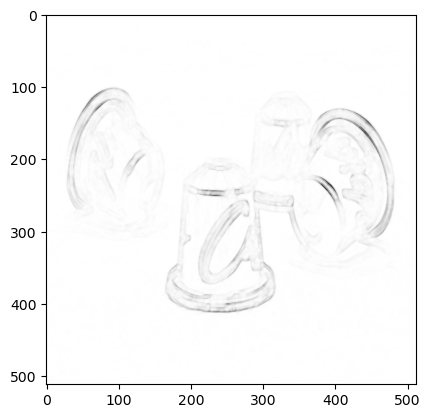

In [29]:
n_streams = 10
num_cycles = 5
blocks = (16, 16)
threads_per_block = (32, 32)
images = data['data'][:360]

img = filtros_con_streams(images,n_streams,num_cycles,blocks,threads_per_block)
fig, ax = plt.subplots()
im = ax.imshow(img[3], cmap='Greys')

## Tiempos

In [30]:
n_streams = 5
num_cycles = 5
blocks = (16, 16)
threads_per_block = (32, 32)
images = data['data'][:360]

filtered_images = filtros_con_streams(images,n_streams,num_cycles,blocks,threads_per_block)
filtered_images = filter_images_mono_stream(images,num_cycles,blocks,threads_per_block)
filtered_images = filter_images_stream_per_kernel(images,num_cycles,blocks,threads_per_block)
filter_images = popurri(images,num_cycles,blocks,threads_per_block)

Filtrado realizado con 5 en 3761.47 ms.
Filtrado realizado con 1 (uno) en 4141.74 ms.
Filtrado realizado con stream por kernel en 3706.95 ms.
Filtrado realizado con mucho cariño en 3293.09 ms.


## Resultados obtenidos
En este apartado, se exponen diferentes gráficas que representan los resultados obtenidos y que serán motivo de análisis y discusión.

In [ ]:
print("Hello world!")

Hello world!
